In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Clean Data

In [2]:
folder = '../data/clean_data/'

df_categories = pd.read_csv(f'{folder}df_categories.csv')
df_comments = pd.read_parquet(f'{folder}df_comments_video.parquet')
df_transcript = pd.read_csv(f'{folder}df_transcript_original.csv')
df_videos = pd.read_csv(f'{folder}df_video_data.csv')
df_channel = pd.read_csv(f'{folder}df_channel_data.csv')
df_content = pd.read_csv(f'{folder}df_content.csv')

In [10]:
df_videos['tags'].head()

0    ['Education', '2023 Latest AI tools', 'AI for ...
1    ['Facebook A.I. Robots shut down', 'facebook a...
2    ['MATLAB', 'Simulink', 'MathWorks', '624592559...
3                                                   []
4    ['Documentary', 'Documentaries', 'documentarie...
Name: tags, dtype: object

# TF-IDF model for `df_transcripts` and `df_comments`

# Modelo 1

Variables: `clean_text`, `video_id`

In [11]:
model1 = df_content.copy()
model1.head()

,video_id,transcription,language,clean_text,comment_list
0,qtlUwwtvuEg,[Music] thank you hello everyone I hope you ar...,english,music thank hello everyone hope great era ai w...,great videohelpful\n thank well explained vide...
1,QaoDXYYtgK0,number three [Music] Facebook has enacted an e...,english,number three music facebook enacted emergency ...,quotthey invented code languagequot man thats ...
2,PqDwddEHswU,in this series we're going to introduce deep l...,english,series going introduce deep learning least per...,brian douglas hero\n learned far sitting couch...
3,B-Y7rnOa43w,this is how to earn money with AI and it's par...,english,earn money ai part two let go want create kind...,oh im going try\n brilliant
4,vyit-1zKsZ4,when current Medical Science has run out of op...,english,current medical science run option doctor dont...,locked syndrome lateral amyloid multiple scler...



El parámetro ngram_range en TfidfVectorizer se refiere a los tamaños de n-gramas que el vectorizador debe considerar al analizar el texto. Un n-grama es una secuencia de "n" palabras consecutivas en un texto.

Desglose de ngram_range=(1, 2):
Unigrama (1-gram): Es una secuencia de 1 palabra. Si ngram_range=(1, 1), el vectorizador solo consideraría palabras individuales.

Ejemplo: Para la frase "hola mundo", los unigramas serían: ["hola", "mundo"].
Bigramas (2-gram): Es una secuencia de 2 palabras consecutivas. Si ngram_range=(2, 2), el vectorizador solo consideraría pares de palabras consecutivas.

Ejemplo: Para la frase "hola mundo", los bigramas serían: ["hola mundo"].
ngram_range=(1, 2): Con este rango, el vectorizador considerará tanto unigramas como bigramas. Es decir, se generarán características tanto para palabras individuales como para pares de palabras consecutivas.

Ejemplo: Para la frase "hola mundo", los n-gramas serían: ["hola", "mundo", "hola mundo"]

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear el vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Aplicar TF-IDF a comentarios
tfidf_transcripts = tfidf_vectorizer.fit_transform(model1['clean_text'])

# Convertir a DataFrame para visualizar las características
tfidf_transcripts_df = pd.DataFrame(tfidf_transcripts.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(f'tfidf_transcript: {tfidf_transcripts_df.shape}')


tfidf_transcript: (1787, 5000)


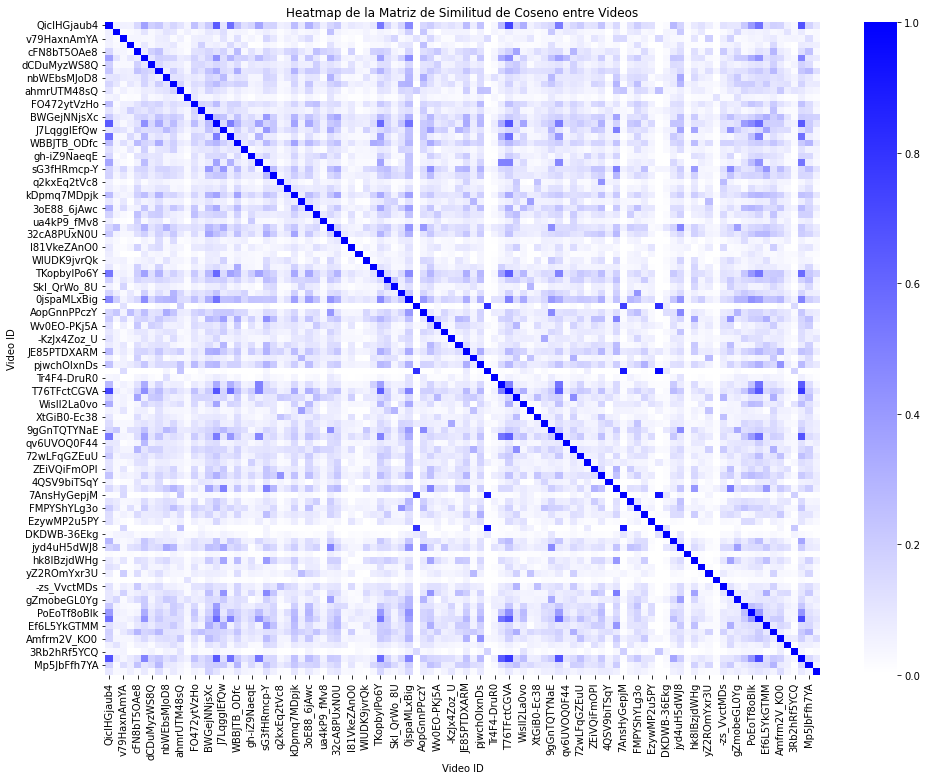

In [64]:
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.colors import LinearSegmentedColormap


cosine_matrix = cosine_similarity(tfidf_transcripts)

cosine_df = pd.DataFrame(cosine_matrix, index=model1['video_id'], columns=model1['video_id'])

# Configurar el tamaño del gráfico
plt.figure(figsize=(16, 12))


# Crear el heatmap con un zoom random
cmap = LinearSegmentedColormap.from_list("white_to_blue", ["white", "blue"])

zoom_size = 100
x = np.random.randint(0, len(cosine_df))
sns.heatmap(cosine_df.iloc[x:x+zoom_size, x:x+zoom_size], cmap=cmap, annot=False)

# Agregar título y etiquetas
plt.title('Heatmap de la Matriz de Similitud de Coseno entre Videos')
plt.xlabel('Video ID')
plt.ylabel('Video ID')

# Mostrar el heatmap
plt.show()

# Get recommendations based on transcriptions `VALID`

La similitud coseno (cosine similarity) es una medida de similitud entre dos vectores en un espacio vectorial que calcula el coseno del ángulo entre ellos. Es ampliamente utilizada en procesamiento de lenguaje natural (NLP), recuperación de información, y otras áreas relacionadas con la comparación de texto o documentos, ya que es eficiente y proporciona una buena estimación de la similitud entre documentos o textos representados como vectores.

In [65]:
from sklearn.metrics.pairwise import cosine_similarity

video_id = np.random.choice(model1['video_id'].unique())

# Extraer el índice del video en el DataFrame
index = model1[model1['video_id'] == video_id].index[0]

# Calcular la similitud del coseno entre este video y todos los demás
cosine_similarities = cosine_similarity(tfidf_transcripts[index], tfidf_transcripts).flatten()

# Crear un DataFrame con los video_ids y las similitudes correspondientes
similar_videos = pd.DataFrame({
    'video_id': model1['video_id'],
    'similarity': cosine_similarities
})

# Ordenar los videos por similitud, excluyendo el propio video
similar_videos = similar_videos[similar_videos['video_id'] != video_id].sort_values(by='similarity', ascending=False)

similar_videos = similar_videos.merge(df_videos[['videoId', 'title']], left_on='video_id', right_on='videoId')
similar_videos.drop(columns='videoId', inplace=True)

similar_videos.head()

,video_id,similarity,title
0,UDQ2gJZqqdE,0.347635,How much does an AI ENGINEER make?
1,OgeWMMVNZhw,0.346391,"Machine Learning Engineer Average Salary, Resu..."
2,fF7PYGkoxNg,0.261638,Career in Robotics | Courses | Future Scope | ...
3,DVbiH_P2ogk,0.251509,"Scope of Artificial Intelligence in India, Cou..."
4,GDCnydDWRnM,0.222360,What is a Machine Learning Engineer


In [22]:
len(cosine_similarities)

1787

# Final Score based on content and comments sentiment

$$
\text{Final Score} = \text{Similar\_Videos} \times (1 + \text{Sentiment\_Score})
$$

In [66]:
df_videos = pd.read_csv('../data/clean_data/df_video_data.csv')
df_videos_modelling = pd.read_csv('../data/clean_data/df_videos_modelling.csv')
titles = df_videos[['videoId', 'title']]

In [67]:
df_merged = df_videos_modelling.merge(similar_videos, on='video_id', how='right')
df_merged = df_merged.merge(titles, left_on='video_id', right_on='videoId', how='left')
df_merged['similarity']

0       0.347635
1       0.346391
2       0.261638
3       0.251509
4       0.222360
          ...   
1675    0.000000
1676    0.000000
1677    0.000000
1678    0.000000
1679    0.000000
Name: similarity, Length: 1680, dtype: float64

In [68]:
df_merged['final_score'] = df_merged['similarity'] * (1 + df_merged['weighted_sentiment'])
df_merged.sort_values(by='final_score', ascending=False, inplace=True)

selected_columns = ['video_id', 'title', 'final_score']
df_merged[selected_columns].head(10)

,video_id,title,final_score
1,OgeWMMVNZhw,"Machine Learning Engineer Average Salary, Resu...",0.513978
2,fF7PYGkoxNg,Career in Robotics | Courses | Future Scope | ...,0.440026
0,UDQ2gJZqqdE,How much does an AI ENGINEER make?,0.432027
3,DVbiH_P2ogk,"Scope of Artificial Intelligence in India, Cou...",0.389143
4,GDCnydDWRnM,What is a Machine Learning Engineer,0.376922
10,t3M_VW5nv5s,"Robotics Engineering | scope, salary, fees, su...",0.316539
8,DP0TKM0S2-8,Data Science vs Machine Learning – What's The ...,0.298563
17,rZn_W7hJ9m8,Personal Finance and AI (Artificial Intelligen...,0.285830
9,spLjYlxzCwk,Career In Artificial Intelligence || Machine L...,0.278416
22,M7WdWtlb_3E,Top Skills EVERY Data Scientist Should Know (i...,0.269366


# CLUSTERING

In [69]:
df_videos = pd.read_csv('../data/clean_data/df_videos_modelling.csv')

In [70]:
# List of nummerical relevant columns
numerical_columns = ['viewCount', 
                      'likeCount', 
                      'commentCount',
                      'total_comments_likes',
                      'licensed', 
                      'duration', 
                      'video_age_days', 
                      'weighted_sentiment',
                      'subscriber_count',
                      'video_count',
                      'view_count',
                      'channel_age_days',
                      'category_Autos & Vehicles',
                      'category_Comedy',
                      'category_Education',
                      'category_Entertainment',
                      'category_Film & Animation',
                      'category_Gaming',
                      'category_Howto & Style',
                      'category_Music',
                      'category_News & Politics',
                      'category_People & Blogs',
                      'category_Pets & Animals',
                      'category_Science & Technology',
                      'category_Sports',
                      'category_Travel & Events'
                      ]

df_videos[numerical_columns].iloc[:5]

,viewCount,likeCount,commentCount,total_comments_likes,licensed,duration,video_age_days,weighted_sentiment,subscriber_count,video_count,...,category_Film & Animation,category_Gaming,category_Howto & Style,category_Music,category_News & Politics,category_People & Blogs,category_Pets & Animals,category_Science & Technology,category_Sports,category_Travel & Events
0,268029,8091,381,290.0,True,1499,479,0.619445,32600,143,...,False,False,False,False,False,False,False,False,False,False
1,3369370,35258,5948,71377.0,False,159,2578,0.062779,18900,5,...,False,False,False,False,False,False,False,False,False,False
2,143984,2575,36,120.0,False,883,1227,0.615898,521000,2741,...,False,False,False,False,False,False,False,True,False,False
3,2430,270,3,0.0,True,44,503,1.000000,60700,909,...,False,False,False,False,False,False,False,True,False,False
4,113233,2030,84,279.0,True,1706,618,0.311447,5700000,1154,...,False,False,False,False,False,False,False,False,False,False


# Standardization

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

video_ids = df_videos['video_id']

videos_standardized = scaler.fit_transform(df_videos[numerical_columns])

df_videos_standardized = pd.DataFrame(videos_standardized, columns=numerical_columns)

df_videos_standardized = pd.concat([video_ids, df_videos_standardized], axis=1)

In [72]:
df_videos_standardized.head()

,video_id,viewCount,likeCount,commentCount,total_comments_likes,licensed,duration,video_age_days,weighted_sentiment,subscriber_count,...,category_Film & Animation,category_Gaming,category_Howto & Style,category_Music,category_News & Politics,category_People & Blogs,category_Pets & Animals,category_Science & Technology,category_Sports,category_Travel & Events
0,qtlUwwtvuEg,-0.025962,-0.017246,0.021028,-0.096125,1.080740,0.059947,-0.633392,0.622073,-0.284323,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,-0.698124,-0.019213,-0.060858
1,QaoDXYYtgK0,1.805809,0.379270,2.783664,2.748875,-0.925292,-0.342024,1.887992,-0.926706,-0.287248,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,-0.698124,-0.019213,-0.060858
2,PqDwddEHswU,-0.099227,-0.097755,-0.150179,-0.102929,-0.925292,-0.124840,0.265129,0.612203,-0.180039,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,1.432411,-0.019213,-0.060858
3,B-Y7rnOa43w,-0.182834,-0.131398,-0.166555,-0.107731,1.080740,-0.376522,-0.604562,1.680867,-0.278323,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,1.432411,-0.019213,-0.060858
4,vyit-1zKsZ4,-0.117390,-0.105710,-0.126358,-0.096565,1.080740,0.122043,-0.466421,-0.234853,0.925785,...,-0.072062,-0.077066,-0.104004,-0.06384,-0.277681,-0.415515,-0.027176,-0.698124,-0.019213,-0.060858


# Correlation Matrix

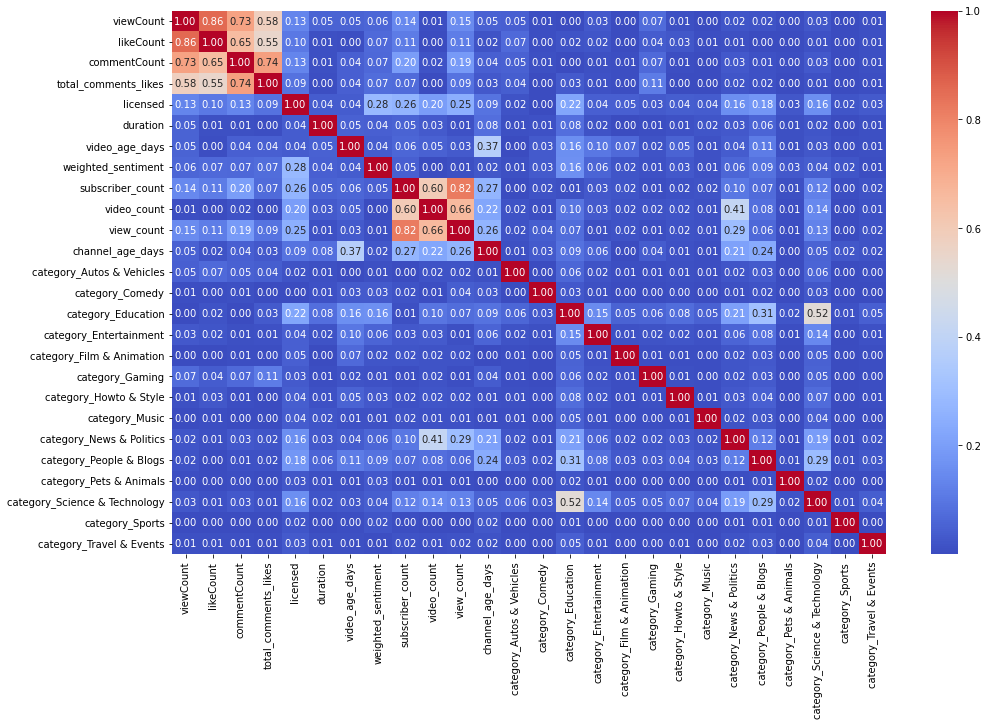

In [73]:
# Create correlation matrix
correlation_matrix = df_videos_standardized[numerical_columns].corr()

plt.figure(figsize=(16,10))
sns.heatmap(np.abs(correlation_matrix), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show();

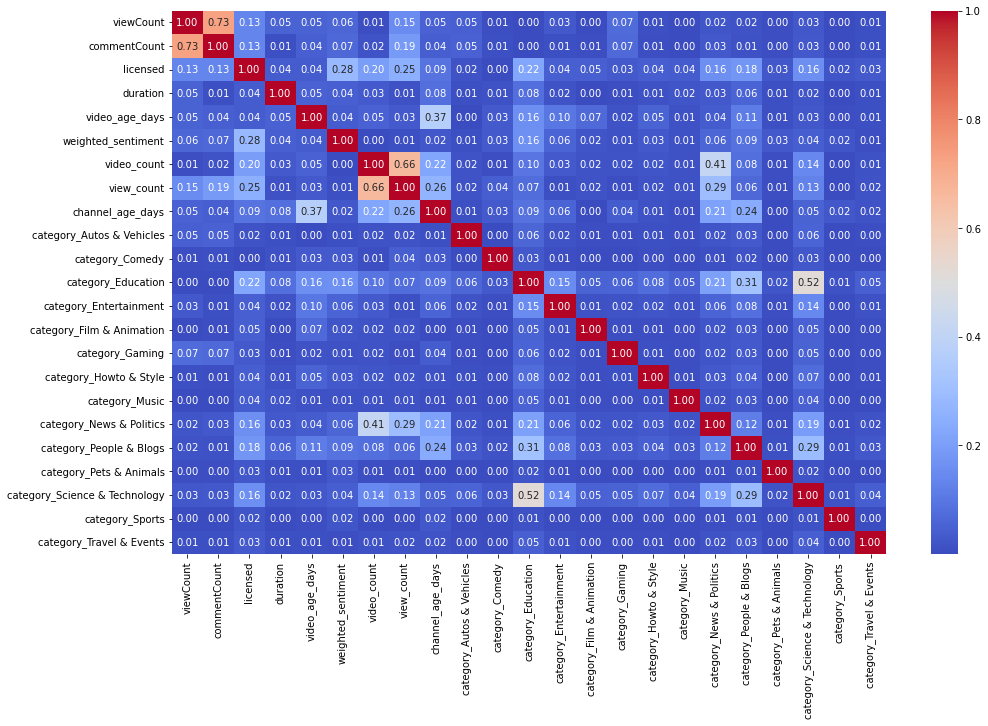

In [74]:
# Let's remove the highest correlated variables
high_correlation_variables = ['likeCount', 'total_comments_likes', 'subscriber_count']

# Drop the columns from standardize dataset
numerical_columns_clean = [column for column in numerical_columns if column not in high_correlation_variables]

# Re-plot the new correlation matrix
correlation_matrix = df_videos_standardized[numerical_columns_clean].corr()
plt.figure(figsize=(16,10))
sns.heatmap(np.abs(correlation_matrix), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show();

In [75]:
df_videos_standardized.dropna(inplace=True)

# K-Means Clustering for Relevance Labeling

In [76]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Initialize the PCA model (for 2 components)
pca = PCA(n_components=2)

# Fit and transform the data
pca_components = pca.fit_transform(df_videos_standardized[numerical_columns_clean])

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])

kmeans = KMeans(n_clusters=3)

kmeans.fit(df_pca.dropna())

df_pca['cluster'] = kmeans.labels_
df_videos['kmeans_cluster'] = kmeans.labels_

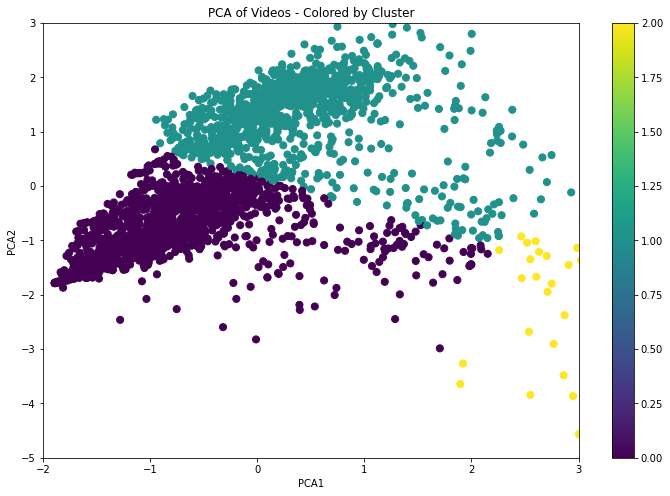

In [77]:
plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50)
plt.colorbar()
plt.title('PCA of Videos - Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim(-2, 3)
plt.ylim(-5, 3)
plt.show()

In [78]:
# Cluster Analysis
# View the number of videos in each cluster
cluster_counts = df_pca['cluster'].value_counts()
print(cluster_counts)

cluster
0    1475
1    1098
2     137
Name: count, dtype: int64


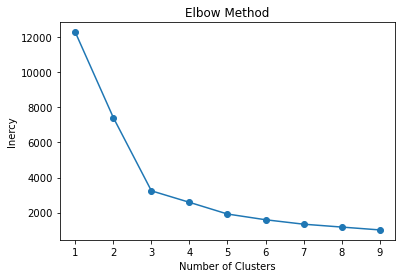

In [79]:
import matplotlib.pyplot as plt

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inercy')
plt.title('Elbow Method')
plt.show()

In [80]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_pca.dropna(), kmeans.labels_)

print(f"The average silhouette score is: {silhouette_avg:.4f}")

The average silhouette score is: 0.4127


# DBSCAN Clustering

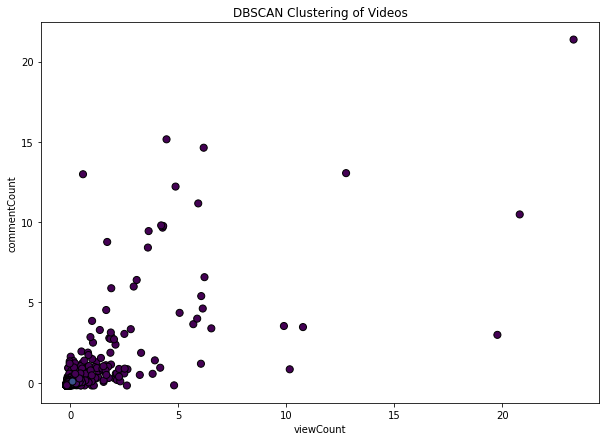

Estimated number of clusters: 35
Estimated number of noise points: 1226


In [81]:
from sklearn.cluster import DBSCAN

# eps: The maximum distance between two samples for them to be considered as in the same neighborhood
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df_videos_standardized[numerical_columns_clean])

# Add the cluster labels to the DataFrame
df_videos_standardized['cluster'] = clusters

# Plotting the clustering result using the first two features
plt.figure(figsize=(10, 7))
plt.scatter(df_videos_standardized[numerical_columns_clean[0]], df_videos_standardized[numerical_columns_clean[1]], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('DBSCAN Clustering of Videos')
plt.xlabel(numerical_columns_clean[0])
plt.ylabel(numerical_columns_clean[1])
plt.show()

# Analyzing the results
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

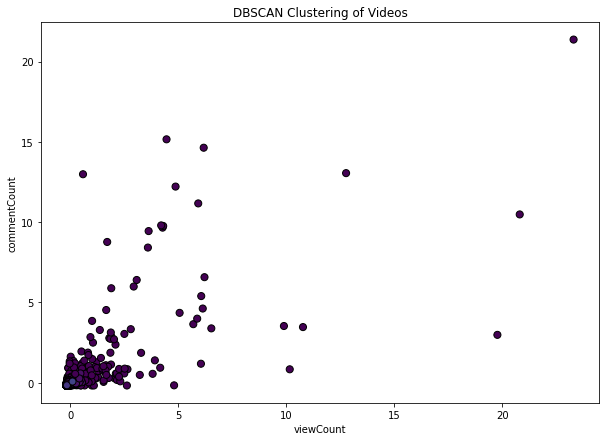

Estimated number of clusters: 25
Estimated number of noise points: 762


In [82]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import pandas as pd

# Assuming df_videos_standardized and numerical_columns_clean are already defined
# Apply DBSCAN

X = df_videos_standardized[numerical_columns_clean]
min_samples = 5

dbscan = DBSCAN(eps=0.7, min_samples=min_samples)
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the DataFrame
df_videos_standardized['cluster'] = clusters

# Plotting the clustering result using the first two features
plt.figure(figsize=(10, 7))
plt.scatter(X['viewCount'], X['commentCount'], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('DBSCAN Clustering of Videos')
plt.xlabel(numerical_columns_clean[0])
plt.ylabel(numerical_columns_clean[1])
plt.show()

# Analyzing the results
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')


<AxesSubplot:xlabel='cluster'>

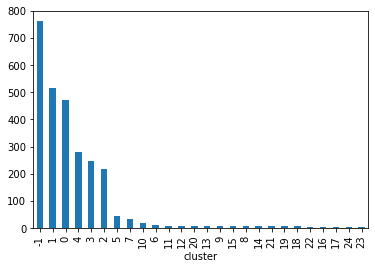

In [83]:
df_videos_standardized['cluster'].value_counts().plot(kind='bar')

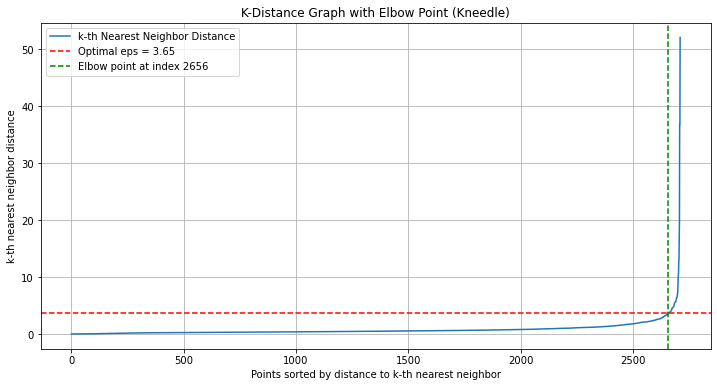

Optimal eps value: 3.6473850096792177


In [84]:
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Setting 'k' equal to min_samples - 1 (assuming min_samples is 4 for this example)
k = min_samples - 1

# Initialize NearestNeighbors with n_neighbors as 'k'
# Use the 'ball_tree' algorithm for efficient distance computation
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)

# Find the distance to the k-th nearest neighbor for each point
# distances: Array of distances to k-th nearest neighbor
# indices: The indices of the k-th nearest neighbor in the dataset
distances, indices = nbrs.kneighbors(X)

# Sort the distances
sorted_distances = np.sort(distances[:, k-1], axis=0)

# Use the KneeLocator to find the elbow
kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')
optimal_eps = sorted_distances[kneedle.elbow]

# Plotting the k-distance Graph
plt.figure(figsize=(12, 6))
plt.plot(sorted_distances, label='k-th Nearest Neighbor Distance')
plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Optimal eps = {optimal_eps:.2f}')
plt.axvline(x=kneedle.elbow, color='g', linestyle='--', label=f'Elbow point at index {kneedle.elbow}')
plt.title('K-Distance Graph with Elbow Point (Kneedle)')
plt.xlabel('Points sorted by distance to k-th nearest neighbor')
plt.ylabel('k-th nearest neighbor distance')
plt.legend()
plt.grid(True)
plt.show()

print(f'Optimal eps value: {optimal_eps}')

In [85]:
df_videos_standardized.to_csv('../data/clean_data/df_videos_standardized.csv', index=False)

# DBScan with PCA Components

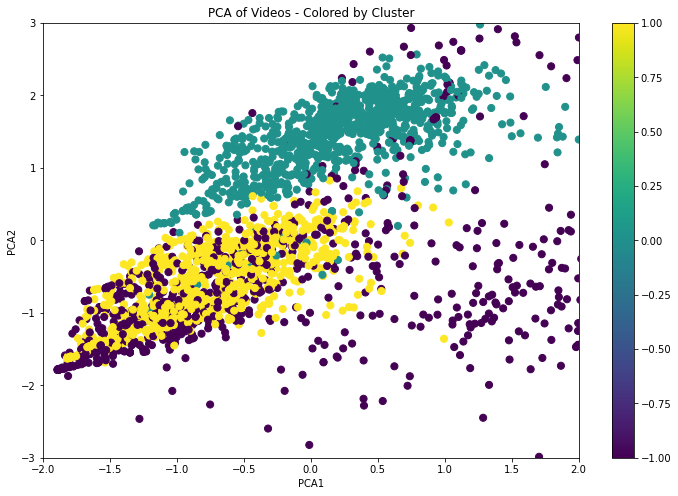

In [86]:
from sklearn.decomposition import PCA

X = df_videos_standardized[numerical_columns_clean].copy()   

# Initialize the PCA model for 2 components
pca = PCA(n_components=2)

# Fit and transform the data using PCA
pca_components = pca.fit_transform(X)

# Create a DataFrame with the PCA results
df_pca = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])

# Apply DBScan using one of the previously suggested combinations
dbscan_model = DBSCAN(eps=2.75, min_samples=600)
dbscan_labels = dbscan_model.fit_predict(X)

# Add the DBScan cluster labels to the PCA DataFrame
df_pca['cluster'] = dbscan_labels

# Display the first few rows of the PCA DataFrame
df_pca.head()

plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50)
plt.colorbar()
plt.title('PCA of Videos - Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.xlim(-2, 2)
plt.ylim(-3,3)
plt.show()

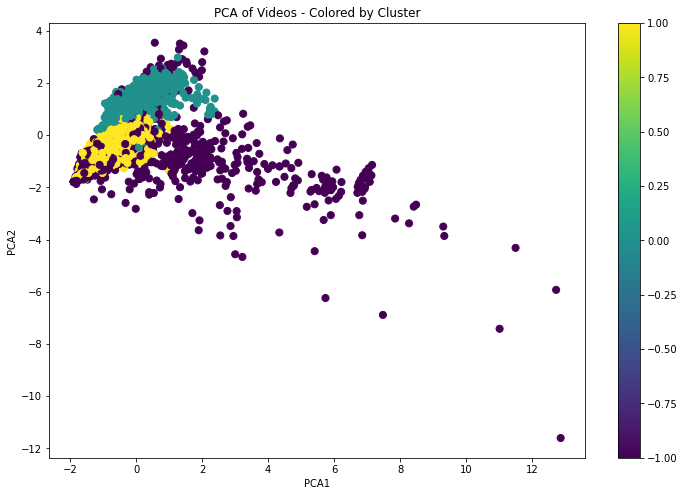

In [87]:
plt.figure(figsize=(12, 8))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['cluster'], cmap='viridis', s=50)
plt.colorbar()
plt.title('PCA of Videos - Colored by Cluster')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

# Hierarchical Clustering

In [91]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
"""
X_pca = pca_components

# Perform hierarchical clustering using Ward's method
linked = linkage(X_pca, method='ward')


# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()


n_clusters = 2
# Perform Agglomerative Clustering based on the dendrogram
# We can decide on the number of clusters based on the dendrogram, let's start with 2 clusters
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hc_labels = hierarchical_clustering.fit_predict(X_pca)

# Add the cluster labels to the PCA DataFrame
df_pca_hc = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca_hc['cluster'] = hc_labels

# Visualizar la clusterización en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los datos con los clusters obtenidos
scatter = ax.scatter(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'], c=hc_labels, cmap='viridis', s=50)

# Añadir etiquetas y título
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title(f'Clusterización Jerárquica en 3D con {n_clusters} Clusters')

# Añadir una barra de colores
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()
"""

'\nX_pca = pca_components\n\n# Perform hierarchical clustering using Ward\'s method\nlinked = linkage(X_pca, method=\'ward\')\n\n\n# Plot the dendrogram\nplt.figure(figsize=(10, 7))\ndendrogram(linked,\n           orientation=\'top\',\n           distance_sort=\'descending\',\n           show_leaf_counts=False)\nplt.title(\'Dendrogram for Hierarchical Clustering\')\nplt.xlabel(\'Samples\')\nplt.ylabel(\'Euclidean distances\')\nplt.show()\n\n\nn_clusters = 2\n# Perform Agglomerative Clustering based on the dendrogram\n# We can decide on the number of clusters based on the dendrogram, let\'s start with 2 clusters\nhierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=\'ward\')\nhc_labels = hierarchical_clustering.fit_predict(X_pca)\n\n# Add the cluster labels to the PCA DataFrame\ndf_pca_hc = pd.DataFrame(X_pca, columns=[\'PCA1\', \'PCA2\', \'PCA3\'])\ndf_pca_hc[\'cluster\'] = hc_labels\n\n# Visualizar la clusterización en 3D\nfig = plt.figure(figsize=(10, 8))\

In [92]:
# df_pca_hc['cluster'].value_counts().plot(kind='bar')

In [93]:
from sklearn.metrics import silhouette_score

# Assuming clusters are the labels assigned by the GMM model
#sil_score = silhouette_score(X_pca, hc_labels)
#print(f'Silhouette Score: {sil_score}')

# Final Score: TD-IDF * Weighted Sentiment * Kmeans Clusters

In [94]:
df_merged = df_merged.merge(df_videos[['video_id', 'kmeans_cluster']], on='video_id', how='left')
df_merged['kmeans_cluster'].head()

0    0
1    1
2    0
3    1
4    0
Name: kmeans_cluster, dtype: int32

In [95]:
# Boost videos from same cluster
cluster_boost = 1.2  
cluster_number = int(df_videos[df_videos['video_id'] == video_id]['kmeans_cluster'])

# Get cluster boosted final score
df_merged['final_score'] = df_merged[df_merged['kmeans_cluster'] == cluster_number]['final_score'] * cluster_boost

# Order the videos by final_score
df_merged.sort_values(by='final_score', ascending=False, inplace=True)

/tmp/ipykernel_23223/2965804949.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster_number = int(df_videos[df_videos['video_id'] == video_id]['kmeans_cluster'])


In [96]:
selected_columns = ['video_id', 'title', 'final_score']
video_title = df_videos[df_videos['video_id'] == video_id]['title']
print(f'{video_id}: {video_title}')
df_merged[selected_columns].head(10)

Eg25OnvTxBY: 605    Artificial Intelligence & Machine Learning - S...
Name: title, dtype: object


,video_id,title,final_score
1,fF7PYGkoxNg,Career in Robotics | Courses | Future Scope | ...,0.528031
3,DVbiH_P2ogk,"Scope of Artificial Intelligence in India, Cou...",0.466972
5,t3M_VW5nv5s,"Robotics Engineering | scope, salary, fees, su...",0.379847
6,DP0TKM0S2-8,Data Science vs Machine Learning – What's The ...,0.358276
7,rZn_W7hJ9m8,Personal Finance and AI (Artificial Intelligen...,0.342996
10,uBV0w8Qwhv4,How To Become An Artificial Intelligence Engin...,0.323127
13,ajeTYqhRHno,What is Deep Learning? (in 5 Minutes) 🔥🔥,0.297196
14,4U6ueXqZHYs,Data Science Institute in Bangalore | Deep lea...,0.292626
15,ilLDSQwzEuM,NEW BRANCES IN IPU BTECH | AI ML | AI DS | IIO...,0.276911
16,tj-4kPIiceA,B.E /B.Tech in Robotics Science || Admission P...,0.263069


# MODEL EVALUATION

# Precision@K

$$
\text{Precision@K} = \frac{\text{Número de elementos relevantes en el top K}}{K}
$$


# Recall@K
$$
\text{Recall@K} = \frac{\text{Número de elementos relevantes en el top K}}{\text{Número total de elementos relevantes}}
$$


# F1-Score@K
$$
\text{F1-Score@K} = 2 \times \frac{\text{Precision@K} \times \text{Recall@K}}{\text{Precision@K} + \text{Recall@K}}
$$
